<a href="https://colab.research.google.com/github/luisgc2116/Machine-Learning/blob/master/Translation_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Data at: http://www.manythings.org/anki/
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K


import numpy as np
import matplotlib.pyplot as plt

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

  
# make sure we do softmax over the time axis
# expected shape is N x T x D
# note: the latest version of Keras allows you to pass in axis arg
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

# Basic configurations
BATCH_SIZE = 64  
EPOCHS = 100  
LATENT_DIMENSIONALITY = 256  
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_OF_WORDS = 20000
EMBEDDING_DIM = 100

# Separate data into inputs and targets
input_texts = [] 
target_texts = [] 
target_texts_inputs = []

NUM_TRAIN_SAMPLES = 10000  
num_samples = 0
#file_path = '/content/drive/My Drive/spa (1).txt'
file_path_language = 'spa.txt'
for line in open(file_path_language, encoding="utf-8"):
  
  # keep track of limit of samples
  num_samples += 1
  if num_samples > NUM_TRAIN_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # Separate input text and the translation into our sec language
  input_text, translation = line.rstrip().split('\t')

  # Make target input and output using the sentence tags
  target_input = '<sos> ' + translation
  target = translation + ' <eos>'


  input_texts.append(input_text)
  target_texts.append(target)
  target_texts_inputs.append(target_input)

print("Number of samples:", len(input_texts))

Number of samples: 10000


In [32]:
# Tokenize inputs
tokenize_inputs = Tokenizer(num_words=MAX_NUM_OF_WORDS)
tokenize_inputs.fit_on_texts(input_texts)
input_sequences = tokenize_inputs.texts_to_sequences(input_texts)

# Word-to-index mapping for our input language
word2idx_inputs = tokenize_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))


# Tokenize outputs, but don't filter out <sos> and <eos> 
tokenize_outputs = Tokenizer(num_words=MAX_NUM_OF_WORDS, filters='')
tokenize_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenize_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenize_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenize_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)


# Caculate max length input sequence for later padding 
max_len_input = max(len(s) for s in input_sequences)

# Padding sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')


Found 2364 unique input tokens.
Found 6294 unique output tokens.
encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [ 0  0  0  0 14]
decoder_inputs[0]: [   2 1480    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 9)


In [33]:
# Create word-to-vec dict 
print('Loading word vectors...')
word2vec = {}
#path_word2vec = #'/content/drive/My Drive/glove.6B.%sd.txt'
path_word2vec = "glove.6B.%sd.txt"
with open(os.path.join(path_word2vec % EMBEDDING_DIM), encoding="utf-8") as f:
  # Space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))




# Embedding matrix
# Words not found word2vec become vectors of 0s
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_OF_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_OF_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector


# Vector/Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)


# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_categorical_encoded = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_categorical_encoded[i, t, word] = 1

Loading word vectors...
Found 400000 word vectors.
Filling pre-trained embeddings...


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 26s 3ms/step - loss: 2.7114 - acc: 0.6380 - val_loss: 2.7059 - val_acc: 0.6511
Epoch 2/100
8000/8000 [==============================] - 15s 2ms/step - loss: 2.0619 - acc: 0.7096 - val_loss: 2.4403 - val_acc: 0.6711
Epoch 3/100
8000/8000 [==============================] - 15s 2ms/step - loss: 1.8474 - acc: 0.7280 - val_loss: 2.2803 - val_acc: 0.6847
Epoch 4/100
8000/8000 [==============================] - 15s 2ms/step - loss: 1.6850 - acc: 0.7464 - val_loss: 2.1757 - val_acc: 0.7029
Epoch 5/100
8000/8000 [==============================] - 15s 2ms/step - loss: 1.5552 - acc: 0.7619 - val_loss: 2.1068 - val_acc: 0.7114
Epoch 6/100
8000/8000 [==============================] - 15s 2ms/step - loss: 1.4451 - acc: 0.7761 - val_loss: 2.0293 - val_acc: 0.7216
Epoch 7/100
8000/8000 [==============================] - 15s 2ms/step - loss: 1.3476 - acc: 0.7882 - val_loss: 1.9857 - val_acc: 0.7301


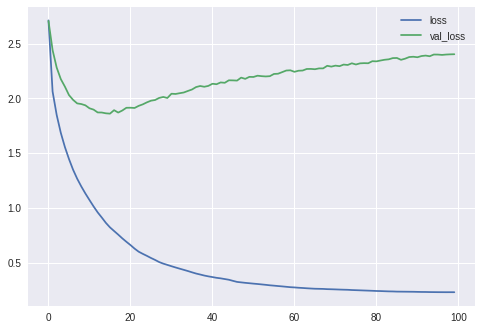

In [36]:
##### build the model #####

LATENT_DIM_DECODER = 256 

# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,
  # dropout=0.5 # dropout not available on gpu
))
encoder_outputs = encoder(x)


# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

######### Attention #########
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context


# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)


# Unlike previous seq2seq, we cannot get the output
# all in one step
# Instead we need to do Ty steps
# And in each of those steps, we need to consider
# all Tx h's

# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)


# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
z = np.zeros((NUM_TRAIN_SAMPLES, LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [37]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)


# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D



# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)



# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}





def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)




while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break


-
Input sentence: Out of my way!
Predicted translation: ¡fuera de mi camino!
Actual translation: ¡Fuera de mi camino! <eos>
Continue? [Y/n]Y
-
Input sentence: Tom died young.
Predicted translation: tom murió joven.
Actual translation: Tom murió joven. <eos>
Continue? [Y/n]Y
-
Input sentence: Will you go?
Predicted translation: ¿va a ir?
Actual translation: ¿Va a ir? <eos>
Continue? [Y/n]Y
-
Input sentence: How lovely!
Predicted translation: ¡qué bonito!
Actual translation: ¡Es una preciosidad! <eos>
Continue? [Y/n]Y
-
Input sentence: What gives?
Predicted translation: ¿qué hay?
Actual translation: ¿Qué pasa? <eos>
Continue? [Y/n]Y
-
Input sentence: I'm educated.
Predicted translation: tengo formación.
Actual translation: Tengo formación. <eos>
Continue? [Y/n]Y
-
Input sentence: I'm finicky.
Predicted translation: soy quisquilloso.
Actual translation: Soy quisquilloso. <eos>
Continue? [Y/n]Y
-
Input sentence: We have a plan.
Predicted translation: tenemos un plan.
Actual translation: Te

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 7s 898us/step - loss: 2.6380 - acc: 0.6593 - val_loss: 2.5789 - val_acc: 0.6579
Epoch 2/100
8000/8000 [==============================] - 6s 696us/step - loss: 2.0155 - acc: 0.7144 - val_loss: 2.3929 - val_acc: 0.6743
Epoch 3/100
8000/8000 [==============================] - 6s 695us/step - loss: 1.8072 - acc: 0.7362 - val_loss: 2.2471 - val_acc: 0.6899
Epoch 4/100
8000/8000 [==============================] - 6s 695us/step - loss: 1.6478 - acc: 0.7542 - val_loss: 2.1567 - val_acc: 0.7067
Epoch 5/100
8000/8000 [==============================] - 6s 698us/step - loss: 1.5172 - acc: 0.7683 - val_loss: 2.0685 - val_acc: 0.7198
Epoch 6/100
8000/8000 [==============================] - 6s 695us/ste

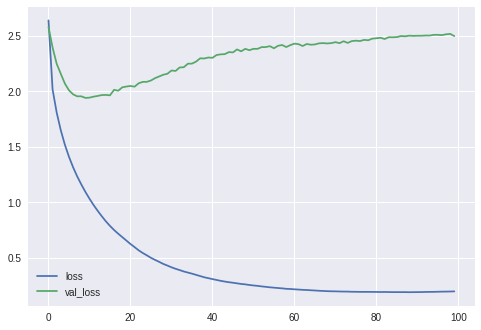

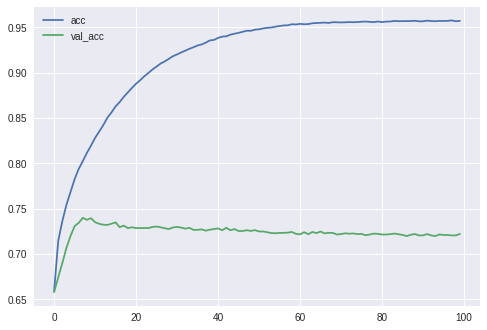

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [9]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIMENSIONALITY,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIMENSIONALITY)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIMENSIONALITY,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

# Compile the model and train it
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_categorical_encoded,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Save model
model.save('s2s.h5')



In [10]:

##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIMENSIONALITY,))
decoder_state_input_c = Input(shape=(LATENT_DIMENSIONALITY,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs,
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

-
Input: I study English.
Translation: estudio francés.
Continue? [Y/n]Y
-
Input: I get by.
Translation: me las arreglo.
Continue? [Y/n]Y
-
Input: Leave a message.
Translation: sal a una encanta el no te yo la
Continue? [Y/n]Y
-
Input: Is he Japanese?
Translation: ¿es él japonés?
Continue? [Y/n]Y
-
Input: I'm freezing.
Translation: estoy helado.
Continue? [Y/n]Y
-
Input: I see the crown.
Translation: veo una veo de
Continue? [Y/n]Y
-
Input: I can't say.
Translation: no puedo decir.
Continue? [Y/n]Y
-
Input: She's my sister.
Translation: ella es mi esposa.
Continue? [Y/n]Y
-
Input: I am weak.
Translation: estoy débil.
Continue? [Y/n]Y
-
Input: The boy is kind.
Translation: el eres un adora de es gentil.
Continue? [Y/n]Y
-
Input: Let's come back.
Translation: la vuelve para arriba.
Continue? [Y/n]n


In [0]:
def decode_sequence(input_sequence):
  # Encode the input as state vectors.
  state_val = encoder_model.predict(input_sequence)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + state_val
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + state_val
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    state_val = [h, c]
    # state_val = [h] # gru

  return ' '.join(output_sentence)



while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_sequence = encoder_inputs[i:i+1]
  translation = decode_sequence(input_sequence)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break